In [1]:
import os

os.chdir("../..")

In [3]:
%pip install umap-learn[plot]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch
import umap

from tokenizers import AbsolutePenPositionTokenizer, DeltaPenPositionTokenizer

In [5]:
model = torch.load(
    "logs/sketch_transformer_example0/SketchTransformer_AbsolutePenPositionTokenizer-q32_checkpoint19.pth",
    weights_only=False,
)

tokenizer = AbsolutePenPositionTokenizer(bins=32)

embeddings = model.embed.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

c:\Users\matth\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


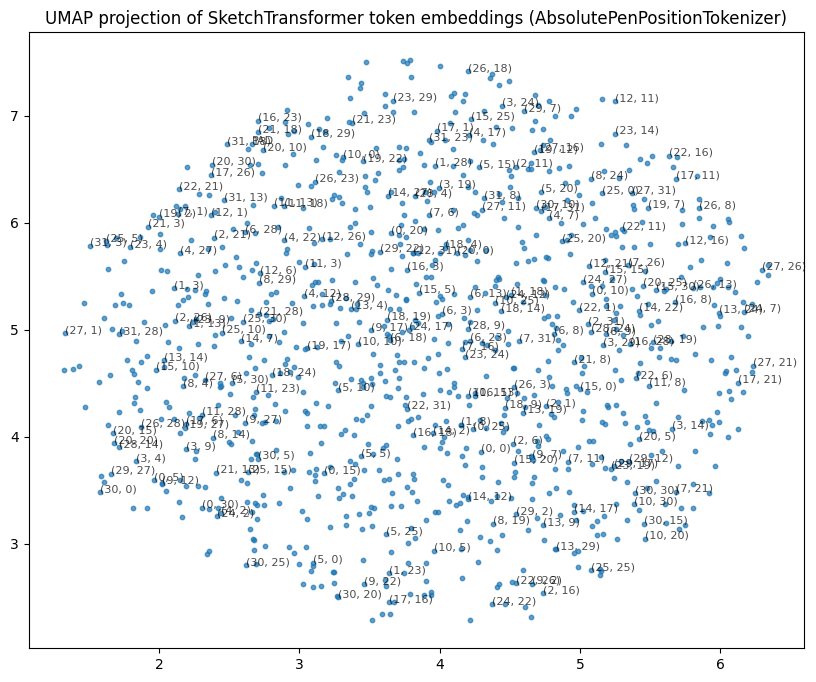

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)

for i in range(
    0, len(embedding_2d), max(1, len(embedding_2d) // 200)
):  # only sample some labels
    plt.text(
        embedding_2d[i, 0],
        embedding_2d[i, 1],
        tokenizer.inv_vocab[i],
        fontsize=8,
        alpha=0.7,
    )

plt.title(
    f"UMAP projection of SketchTransformer token embeddings ({tokenizer.__class__.__name__})"
)
plt.show()

In [9]:
model = torch.load(
    "logs/sketch_transformer_example1/SketchTransformer_DeltaPenPositionTokenizer-q32_checkpoint14.pth",
    weights_only=False,
)

tokenizer = DeltaPenPositionTokenizer(bins=32)

embeddings = model.embed.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric="cosine", random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

c:\Users\matth\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


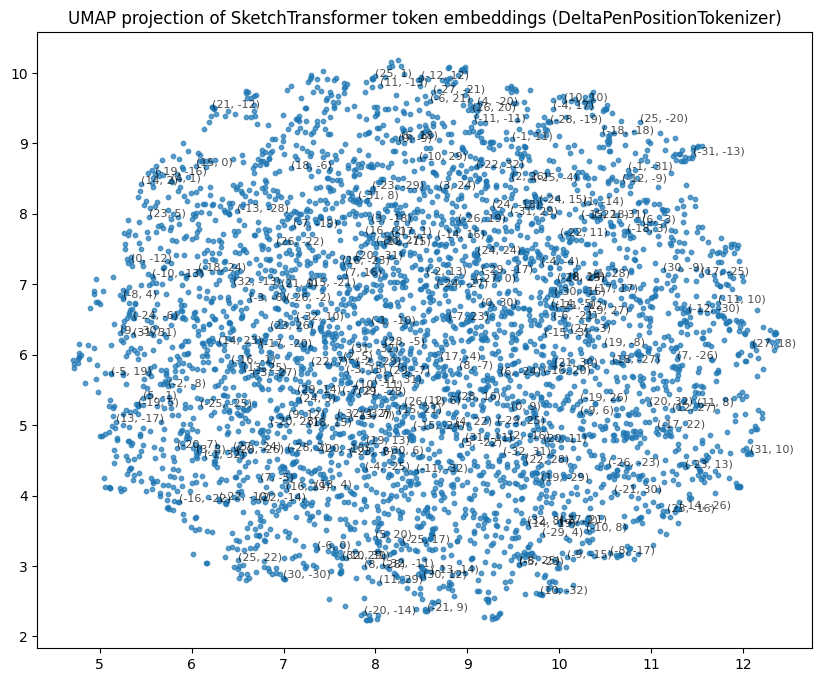

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)

for i in range(
    0, len(embedding_2d), max(1, len(embedding_2d) // 200)
):  # only sample some labels
    plt.text(
        embedding_2d[i, 0],
        embedding_2d[i, 1],
        tokenizer.inv_vocab[i],
        fontsize=8,
        alpha=0.7,
    )

plt.title(
    f"UMAP projection of SketchTransformer token embeddings ({tokenizer.__class__.__name__})"
)
plt.show()

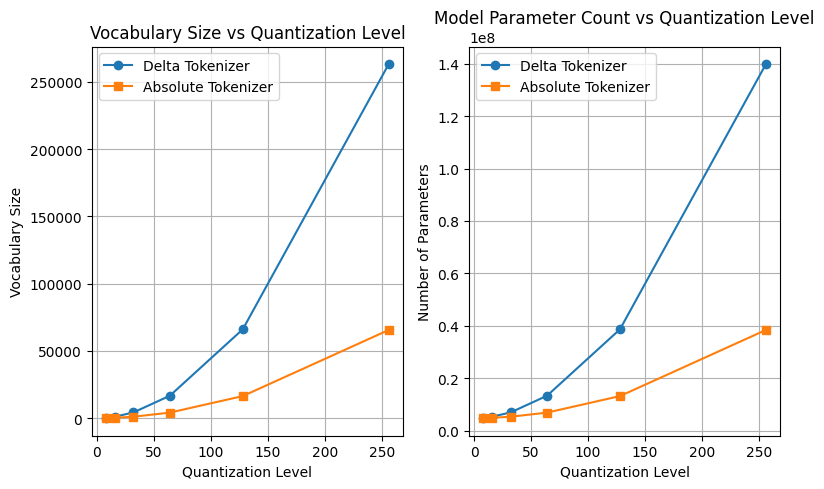

In [5]:
import matplotlib.pyplot as plt
from tokenizers import DeltaPenPositionTokenizer, AbsolutePenPositionTokenizer
from models import SketchTransformer

# Graph the vocabulary size of different Tokenizers, show the relationship is quadratic to the size of possible positions
# x = quantization level, y = vocabulary size
# x = quantization level, y is network size num of parameters (with baseline hparams)

quant_levels = [8, 16, 32, 64, 128, 256]
delta_vocab_sizes = []
abs_vocab_sizes = []
delta_params = []
abs_params = []

for q_level in quant_levels:
    # Delta tokenizer
    delta_tokenizer = DeltaPenPositionTokenizer(q_level)
    delta_vocab = len(delta_tokenizer.vocab)
    delta_vocab_sizes.append(delta_vocab)
    delta_model = SketchTransformer(delta_vocab)
    delta_params.append(sum(p.numel() for p in delta_model.parameters()))

    # Absolute tokenizer
    abs_tokenizer = AbsolutePenPositionTokenizer(q_level)
    abs_vocab = len(abs_tokenizer.vocab)
    abs_vocab_sizes.append(abs_vocab)
    abs_model = SketchTransformer(abs_vocab)
    abs_params.append(sum(p.numel() for p in abs_model.parameters()))

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Plot 1: Vocabulary size vs Quantization level
axes[0].plot(quant_levels, delta_vocab_sizes, marker="o", label="Delta Tokenizer")
axes[0].plot(quant_levels, abs_vocab_sizes, marker="s", label="Absolute Tokenizer")
axes[0].set_title("Vocabulary Size vs Quantization Level")
axes[0].set_xlabel("Quantization Level")
axes[0].set_ylabel("Vocabulary Size")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Model size vs Quantization level
axes[1].plot(quant_levels, delta_params, marker="o", label="Delta Tokenizer")
axes[1].plot(quant_levels, abs_params, marker="s", label="Absolute Tokenizer")
axes[1].set_title("Model Parameter Count vs Quantization Level")
axes[1].set_xlabel("Quantization Level")
axes[1].set_ylabel("Number of Parameters")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

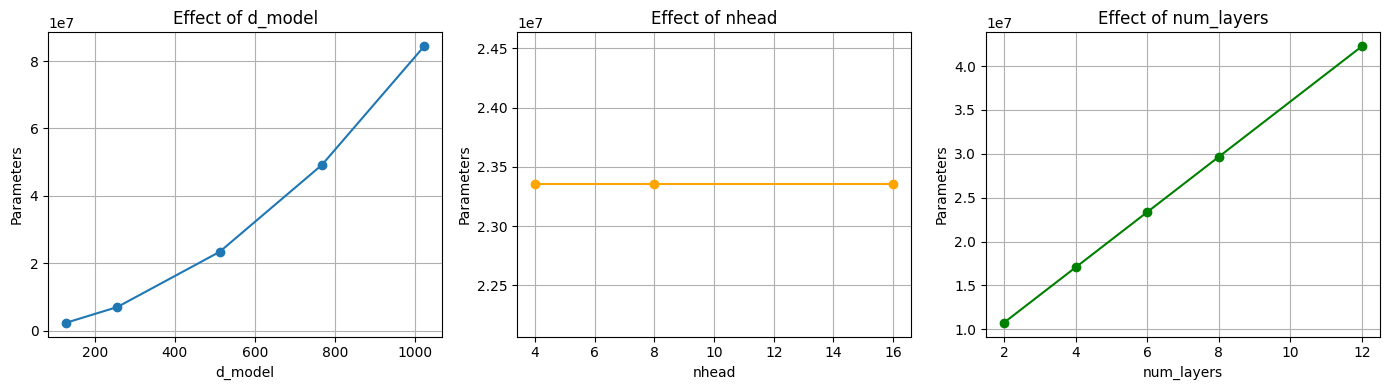

In [ ]:
import matplotlib.pyplot as plt
from tokenizers import DeltaPenPositionTokenizer
from models import SketchTransformer

tokenizer = DeltaPenPositionTokenizer(32)
vocab_size = len(tokenizer.vocab)

# hyperparameter ranges
d_models = [128, 256, 512, 768, 1024]
nheads = [4, 8, 12, 16]
layers = [2, 4, 6, 8, 12]


def count_params(model):
    return sum(p.numel() for p in model.parameters())


# d_model vs param count
param_counts_dmodel = []
valid_dmodels = []
for d in d_models:
    if d % 8 != 0:  # ensure divisible by default nhead=8
        continue
    model = SketchTransformer(vocab_size, d_model=d, nhead=8, num_layers=6, max_len=200)
    param_counts_dmodel.append(count_params(model))
    valid_dmodels.append(d)

# nhead vs param count (only valid when divides d_model)
param_counts_nhead = []
valid_nheads = []
for n in nheads:
    if 512 % n != 0:  # fixed d_model=512
        continue
    model = SketchTransformer(
        vocab_size, d_model=512, nhead=n, num_layers=6, max_len=200
    )
    param_counts_nhead.append(count_params(model))
    valid_nheads.append(n)

# num_layers vs param count (no restriction)
param_counts_layers = []
for l in layers:
    model = SketchTransformer(
        vocab_size, d_model=512, nhead=8, num_layers=l, max_len=200
    )
    param_counts_layers.append(count_params(model))


fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(valid_dmodels, param_counts_dmodel, marker="o")
axes[0].set_title("Effect of d_model")
axes[0].set_xlabel("d_model")
axes[0].set_ylabel("Parameters")
axes[0].grid(True)

axes[1].plot(valid_nheads, param_counts_nhead, marker="o", color="orange")
axes[1].set_title("Effect of nhead")
axes[1].set_xlabel("nhead")
axes[1].set_ylabel("Parameters")
axes[1].grid(True)

axes[2].plot(layers, param_counts_layers, marker="o", color="green")
axes[2].set_title("Effect of num_layers")
axes[2].set_xlabel("num_layers")
axes[2].set_ylabel("Parameters")
axes[2].grid(True)

plt.tight_layout()
plt.show()